In [58]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [59]:
import pandas as pd
import joblib

In [100]:
# Load your preprocessed DataFrame
df_final = pd.read_csv("/content/drive/MyDrive/SMAI_project/df_final.csv")

In [101]:
df = pd.read_csv("/content/drive/MyDrive/SMAI_project/df.csv")

### Prediction of runs

In [62]:
def predict_runs_for_team(df, model, player_country, opposition_country, venue_type):
    # Filter the dataframe based on the specified player_country, opposition_country, and venue_type
    filtered_df = df[
        (df["player_country"] == player_country) &
        (df["opposition_country"] == opposition_country) &
        (df["venue_type"] == venue_type)
    ]

    if filtered_df.empty:
        print("No data found for this combination.")
        return None

    # Ensure that the data used for prediction is correctly preprocessed
    feature_cols = ["4s", "6s", "strike_rate", "year", "BF", "player_country", "opposition_country", "venue_type"]

    # Handle missing data if any (can fill with zeros or mean depending on your requirement)
    filtered_df = filtered_df.fillna(0)  # Or you can choose other methods like mean or median

    # Prepare the features (X)
    X = filtered_df[feature_cols].copy()

    # Ensure categorical variables are encoded (if necessary)
    # Check if the model has been trained with the correct encoding
    if hasattr(model, "transform") and callable(getattr(model, "transform", None)):
        X = model.named_steps["preprocessor"].transform(X)  # If model includes preprocessing steps (like one-hot encoding)

    # Predict the runs for the filtered data
    predicted_runs = model.predict(X)

    # Create a DataFrame with the player names and their predicted runs
    result_df = filtered_df[["player"]].copy()
    result_df["predicted_runs"] = predicted_runs

    return result_df


### Prediction of top 4 batters

In [63]:
# Function to predict runs for a given DataFrame and best model
def predict_top_batters(player_df, best_model, top_n=4):
    # Prepare the feature columns
    X = player_df[["4s", "6s", "strike_rate", "BF", "year"]].copy()

    # Predict using the best model
    predicted_runs = best_model.predict(X)

    # Add predictions to DataFrame
    results_df = player_df[["player", "player_country", "opposition_country", "venue_type"]].copy()
    results_df["predicted_runs"] = predicted_runs

    # Remove duplicates and get highest prediction per player
    results_unique = results_df.groupby("player", as_index=False)["predicted_runs"].max()

    # Add context columns back (optional, for clarity)
    context = results_df.drop_duplicates(subset=["player"])[["player", "player_country", "opposition_country", "venue_type"]]
    final_results = pd.merge(results_unique, context, on="player", how="left")

    # Sort by predicted runs and return top N batters
    top_batters = final_results.sort_values(by="predicted_runs", ascending=False).head(top_n)

    return top_batters


### Random Forest Regressor

In [64]:
top_batters_by_model = {}


In [65]:
# Load the model
model_path = "/content/drive/MyDrive/SMAI_project/random_forest_model.pkl"
model = joblib.load(model_path)

# Input values
player_country = "India"
opposition_country = "Australia"
venue_type = "home"

# Step 1: Filter raw df
filtered_df = df[
    (df["player_country"] == player_country) &
    (df["opposition_country"] == opposition_country) &
    (df["venue_type"] == venue_type)
]

if filtered_df.empty:
    print("No data found for the given input.")
else:
    # Step 2: Match rows in df_final using index
    filtered_df_final = df_final.loc[filtered_df.index]

    # Step 3: Ensure correct feature columns (exclude target/irrelevant)
    feature_cols = [col for col in df_final.columns if col not in ["player", "runs"]]

    # Step 4: Predict runs
    X = filtered_df[["4s", "6s", "strike_rate", "BF", "year"]]
    #X = filtered_df_final[feature_cols]
    predicted_runs = model.predict(X)

    # Step 5: Use your function structure
    result_df = filtered_df[["player"]].copy()
    result_df["predicted_runs"] = predicted_runs

    print("\n✅ Predicted Runs for Players:")
    print(result_df)

    # Step 6: Prepare player_df (raw version) with added predictions
    player_df = filtered_df.copy()
    player_df["predicted_runs"] = predicted_runs

        # Step 7: Use your predict_top_batters function
    def predict_top_batters(player_df, top_n=4):
        results_df = player_df[["player", "player_country", "opposition_country", "venue_type", "predicted_runs"]].copy()

        # Get max predicted run per player
        results_unique = results_df.groupby("player", as_index=False)["predicted_runs"].max()

        # Add back context (optional)
        context = results_df.drop_duplicates(subset=["player"])[["player", "player_country", "opposition_country", "venue_type"]]
        final_results = pd.merge(results_unique, context, on="player", how="left")

        # Sort and get top N
        top_batters = final_results.sort_values(by="predicted_runs", ascending=False).head(top_n)
        return top_batters

    top_rf = predict_top_batters(player_df)

    print("\n🏏 Top 4 Predicted Batters (RandomForest):")
    print(top_rf)

    # ✅ Save results for comparison
    top_batters_by_model["RandomForest"] = top_rf




✅ Predicted Runs for Players:
             player  predicted_runs
179         V Kohli           81.75
251    Yuvraj Singh           76.68
347         V Kohli           71.78
379       HH Pandya           71.13
446        SA Yadav           69.26
...             ...             ...
14388       RR Pant            1.00
14718      KL Rahul            1.00
14829     YS Chahal            0.00
15553       V Kohli            0.00
16296      SA Yadav            0.00

[66 rows x 2 columns]

🏏 Top 4 Predicted Batters (RandomForest):
          player  predicted_runs player_country opposition_country venue_type
20       V Kohli           81.75          India          Australia       home
23  Yuvraj Singh           76.68          India          Australia       home
3      HH Pandya           71.13          India          Australia       home
17      SA Yadav           69.26          India          Australia       home


### Decision Tree Regressor

In [66]:
# Load the model
model_path = "/content/drive/MyDrive/SMAI_project/decision_tree_model.pkl"  # Change path if necessary
model = joblib.load(model_path)

# Input values
player_country = "India"
opposition_country = "Australia"
venue_type = "home"

# Step 1: Filter raw df
filtered_df = df[
    (df["player_country"] == player_country) &
    (df["opposition_country"] == opposition_country) &
    (df["venue_type"] == venue_type)
]

if filtered_df.empty:
    print("No data found for the given input.")
else:
    # Step 2: Match rows in df_final using index
    filtered_df_final = df_final.loc[filtered_df.index]

    # Step 3: Ensure correct feature columns (exclude target/irrelevant)
    feature_cols = [col for col in df_final.columns if col not in ["player", "runs"]]

    # Step 4: Predict runs
    X = filtered_df[["4s", "6s", "strike_rate", "BF", "year"]]  # Use the raw features
    predicted_runs = model.predict(X)

    # Step 5: Use your function structure
    result_df = filtered_df[["player"]].copy()
    result_df["predicted_runs"] = predicted_runs

    print("\n✅ Predicted Runs for Players:")
    print(result_df)

    # Step 6: Prepare player_df (raw version) with added predictions
    player_df = filtered_df.copy()
    player_df["predicted_runs"] = predicted_runs

        # Step 7: Use your predict_top_batters function
    def predict_top_batters(player_df, top_n=4):
        results_df = player_df[["player", "player_country", "opposition_country", "venue_type", "predicted_runs"]].copy()

        # Get max predicted run per player
        results_unique = results_df.groupby("player", as_index=False)["predicted_runs"].max()

        # Add back context (optional)
        context = results_df.drop_duplicates(subset=["player"])[["player", "player_country", "opposition_country", "venue_type"]]
        final_results = pd.merge(results_unique, context, on="player", how="left")

        # Sort and get top N
        top_batters = final_results.sort_values(by="predicted_runs", ascending=False).head(top_n)
        return top_batters

    top_dt = predict_top_batters(player_df)

    print("\n🏏 Top 4 Predicted Batters (DecisionTree):")
    print(top_dt)

    # ✅ Save results for comparison
    top_batters_by_model["DecisionTree"] = top_dt




✅ Predicted Runs for Players:
             player  predicted_runs
179         V Kohli            82.0
251    Yuvraj Singh            81.0
347         V Kohli            72.0
379       HH Pandya            70.0
446        SA Yadav            69.0
...             ...             ...
14388       RR Pant             1.0
14718      KL Rahul             1.0
14829     YS Chahal             0.0
15553       V Kohli             0.0
16296      SA Yadav             0.0

[66 rows x 2 columns]

🏏 Top 4 Predicted Batters (DecisionTree):
          player  predicted_runs player_country opposition_country venue_type
20       V Kohli            82.0          India          Australia       home
23  Yuvraj Singh            81.0          India          Australia       home
3      HH Pandya            70.0          India          Australia       home
17      SA Yadav            69.0          India          Australia       home


### Gradient Boosting Regressor

In [67]:
# Load the Gradient Boosting model
model_path = "/content/drive/MyDrive/SMAI_project/gradient_boosting_model.pkl"  # Change path if necessary
model = joblib.load(model_path)

# Input values
player_country = "India"
opposition_country = "Australia"
venue_type = "home"

# Step 1: Filter raw df
filtered_df = df[
    (df["player_country"] == player_country) &
    (df["opposition_country"] == opposition_country) &
    (df["venue_type"] == venue_type)
]

if filtered_df.empty:
    print("No data found for the given input.")
else:
    # Step 2: Match rows in df_final using index
    filtered_df_final = df_final.loc[filtered_df.index]

    # Step 3: Ensure correct feature columns (exclude target/irrelevant)
    feature_cols = [col for col in df_final.columns if col not in ["player", "runs"]]

    # Step 4: Predict runs
    X = filtered_df[["4s", "6s", "strike_rate", "BF", "year"]]  # Use the raw features
    predicted_runs = model.predict(X)

    # Step 5: Use your function structure
    result_df = filtered_df[["player"]].copy()
    result_df["predicted_runs"] = predicted_runs

    print("\n✅ Predicted Runs for Players:")
    print(result_df)

    # Step 6: Prepare player_df (raw version) with added predictions
    player_df = filtered_df.copy()
    player_df["predicted_runs"] = predicted_runs

        # Step 7: Use your predict_top_batters function
    def predict_top_batters(player_df, top_n=4):
        results_df = player_df[["player", "player_country", "opposition_country", "venue_type", "predicted_runs"]].copy()

        # Get max predicted run per player
        results_unique = results_df.groupby("player", as_index=False)["predicted_runs"].max()

        # Add back context (optional)
        context = results_df.drop_duplicates(subset=["player"])[["player", "player_country", "opposition_country", "venue_type"]]
        final_results = pd.merge(results_unique, context, on="player", how="left")

        # Sort and get top N
        top_batters = final_results.sort_values(by="predicted_runs", ascending=False).head(top_n)
        return top_batters

    top_gb = predict_top_batters(player_df)

    print("\n🏏 Top 4 Predicted Batters (GradientBoosting):")
    print(top_gb)

    # ✅ Save results for comparison
    top_batters_by_model["GradientBoosting"] = top_gb



✅ Predicted Runs for Players:
             player  predicted_runs
179         V Kohli       82.583195
251    Yuvraj Singh       76.352350
347         V Kohli       70.033223
379       HH Pandya       70.215117
446        SA Yadav       68.916818
...             ...             ...
14388       RR Pant        1.594742
14718      KL Rahul        0.521525
14829     YS Chahal        0.456032
15553       V Kohli       -0.168115
16296      SA Yadav       -0.158303

[66 rows x 2 columns]

🏏 Top 4 Predicted Batters (GradientBoosting):
          player  predicted_runs player_country opposition_country venue_type
20       V Kohli       82.583195          India          Australia       home
23  Yuvraj Singh       76.352350          India          Australia       home
3      HH Pandya       70.215117          India          Australia       home
17      SA Yadav       68.916818          India          Australia       home


### Ada Boosting Regressor

In [68]:
# Load the AdaBoost model
model_path = "/content/drive/MyDrive/SMAI_project/adaboost_model.pkl"  # Change path if necessary
model = joblib.load(model_path)

# Input values
player_country = "India"
opposition_country = "Australia"
venue_type = "home"

# Step 1: Filter raw df
filtered_df = df[
    (df["player_country"] == player_country) &
    (df["opposition_country"] == opposition_country) &
    (df["venue_type"] == venue_type)
]

if filtered_df.empty:
    print("No data found for the given input.")
else:
    # Step 2: Match rows in df_final using index
    filtered_df_final = df_final.loc[filtered_df.index]

    # Step 3: Ensure correct feature columns (exclude target/irrelevant)
    feature_cols = [col for col in df_final.columns if col not in ["player", "runs"]]

    # Step 4: Predict runs
    X = filtered_df[["4s", "6s", "strike_rate", "BF", "year"]]  # Use the raw features
    predicted_runs = model.predict(X)

    # Step 5: Use your function structure
    result_df = filtered_df[["player"]].copy()
    result_df["predicted_runs"] = predicted_runs

    print("\n✅ Predicted Runs for Players:")
    print(result_df)

    # Step 6: Prepare player_df (raw version) with added predictions
    player_df = filtered_df.copy()
    player_df["predicted_runs"] = predicted_runs

    # Step 7: Use your predict_top_batters function
    def predict_top_batters(player_df, top_n=4):
        results_df = player_df[["player", "player_country", "opposition_country", "venue_type", "predicted_runs"]].copy()

        # Get max predicted run per player
        results_unique = results_df.groupby("player", as_index=False)["predicted_runs"].max()

        # Add back context (optional)
        context = results_df.drop_duplicates(subset=["player"])[["player", "player_country", "opposition_country", "venue_type"]]
        final_results = pd.merge(results_unique, context, on="player", how="left")

        # Sort and get top N
        top_batters = final_results.sort_values(by="predicted_runs", ascending=False).head(top_n)
        return top_batters

    top_ab = predict_top_batters(player_df)

    print("\n🏏 Top 4 Predicted Batters (AdaBoosting):")
    print(top_ab)

    # ✅ Save results for comparison
    top_batters_by_model["AdaBoosting"] = top_ab



✅ Predicted Runs for Players:
             player  predicted_runs
179         V Kohli       80.001360
251    Yuvraj Singh       71.199338
347         V Kohli       69.091222
379       HH Pandya       71.199338
446        SA Yadav       71.730832
...             ...             ...
14388       RR Pant       11.715323
14718      KL Rahul       11.669776
14829     YS Chahal       11.669776
15553       V Kohli       11.669776
16296      SA Yadav       11.669776

[66 rows x 2 columns]

🏏 Top 4 Predicted Batters (AdaBoosting):
          player  predicted_runs player_country opposition_country venue_type
20       V Kohli       80.001360          India          Australia       home
17      SA Yadav       71.730832          India          Australia       home
3      HH Pandya       71.199338          India          Australia       home
23  Yuvraj Singh       71.199338          India          Australia       home


### Gaussian Process Regressor

In [69]:
# Load the Gaussian Process model
model_path = "/content/drive/MyDrive/SMAI_project/gaussian_process_model.pkl"  # Change path if necessary
model = joblib.load(model_path)

# Input values
player_country = "India"
opposition_country = "Australia"
venue_type = "home"

# Step 1: Filter raw df
filtered_df = df[
    (df["player_country"] == player_country) &
    (df["opposition_country"] == opposition_country) &
    (df["venue_type"] == venue_type)
]

if filtered_df.empty:
    print("No data found for the given input.")
else:
    # Step 2: Match rows in df_final using index
    filtered_df_final = df_final.loc[filtered_df.index]

    # Step 3: Ensure correct feature columns (exclude target/irrelevant)
    feature_cols = [col for col in df_final.columns if col not in ["player", "runs"]]

    # Step 4: Predict runs
    X = filtered_df[["4s", "6s", "strike_rate", "BF", "year"]]  # Use the raw features
    predicted_runs = model.predict(X)

    # Step 5: Use your function structure
    result_df = filtered_df[["player"]].copy()
    result_df["predicted_runs"] = predicted_runs

    print("\n✅ Predicted Runs for Players:")
    print(result_df)

    # Step 6: Prepare player_df (raw version) with added predictions
    player_df = filtered_df.copy()
    player_df["predicted_runs"] = predicted_runs

       # Step 7: Use your predict_top_batters function
    def predict_top_batters(player_df, top_n=4):
        results_df = player_df[["player", "player_country", "opposition_country", "venue_type", "predicted_runs"]].copy()

        # Get max predicted run per player
        results_unique = results_df.groupby("player", as_index=False)["predicted_runs"].max()

        # Add back context (optional)
        context = results_df.drop_duplicates(subset=["player"])[["player", "player_country", "opposition_country", "venue_type"]]
        final_results = pd.merge(results_unique, context, on="player", how="left")

        # Sort and get top N
        top_batters = final_results.sort_values(by="predicted_runs", ascending=False).head(top_n)
        return top_batters

    top_gp = predict_top_batters(player_df)

    print("\n🏏 Top 4 Predicted Batters (GaussianProcess):")
    print(top_gp)

    # ✅ Save results for comparison
    top_batters_by_model["GaussianProcess"] = top_gp




✅ Predicted Runs for Players:
             player  predicted_runs
179         V Kohli    8.200000e+01
251    Yuvraj Singh    2.793783e-04
347         V Kohli    7.200000e+01
379       HH Pandya    9.099241e-08
446        SA Yadav    6.900000e+01
...             ...             ...
14388       RR Pant    1.000000e+00
14718      KL Rahul    1.000000e+00
14829     YS Chahal   -1.903561e-32
15553       V Kohli   -5.998217e-34
16296      SA Yadav   -1.679111e-33

[66 rows x 2 columns]

🏏 Top 4 Predicted Batters (GaussianProcess):
       player  predicted_runs player_country opposition_country venue_type
20    V Kohli            82.0          India          Australia       home
17   SA Yadav            69.0          India          Australia       home
2   G Gambhir            63.0          India          Australia       home
8    KL Rahul            55.0          India          Australia       home


### Bagging Regressor

In [70]:
# Load the Bagging Regressor model
model_path = "/content/drive/MyDrive/SMAI_project/bagging_regressor_model.pkl"  # Change path if necessary
model = joblib.load(model_path)

# Input values
player_country = "India"
opposition_country = "Australia"
venue_type = "home"

# Step 1: Filter raw df
filtered_df = df[
    (df["player_country"] == player_country) &
    (df["opposition_country"] == opposition_country) &
    (df["venue_type"] == venue_type)
]

if filtered_df.empty:
    print("No data found for the given input.")
else:
    # Step 2: Match rows in df_final using index
    filtered_df_final = df_final.loc[filtered_df.index]

    # Step 3: Ensure correct feature columns (exclude target/irrelevant)
    feature_cols = [col for col in df_final.columns if col not in ["player", "runs"]]

    # Step 4: Predict runs
    X = filtered_df[["4s", "6s", "strike_rate", "BF", "year"]]  # Use the raw features
    predicted_runs = model.predict(X)

    # Step 5: Use your function structure
    result_df = filtered_df[["player"]].copy()
    result_df["predicted_runs"] = predicted_runs

    print("\n✅ Predicted Runs for Players:")
    print(result_df)

    # Step 6: Prepare player_df (raw version) with added predictions
    player_df = filtered_df.copy()
    player_df["predicted_runs"] = predicted_runs

    # Step 7: Use your predict_top_batters function
    def predict_top_batters(player_df, top_n=4):
        results_df = player_df[["player", "player_country", "opposition_country", "venue_type", "predicted_runs"]].copy()

        # Get max predicted run per player
        results_unique = results_df.groupby("player", as_index=False)["predicted_runs"].max()

        # Add back context (optional)
        context = results_df.drop_duplicates(subset=["player"])[["player", "player_country", "opposition_country", "venue_type"]]
        final_results = pd.merge(results_unique, context, on="player", how="left")

        # Sort and get top N
        top_batters = final_results.sort_values(by="predicted_runs", ascending=False).head(top_n)
        return top_batters

    top_bg = predict_top_batters(player_df)

    print("\n🏏 Top 4 Predicted Batters (Bagging):")
    print(top_bg)

    # ✅ Save results for comparison
    top_batters_by_model["Bagging"] = top_bg




✅ Predicted Runs for Players:
             player  predicted_runs
179         V Kohli           81.80
251    Yuvraj Singh           77.06
347         V Kohli           71.92
379       HH Pandya           71.88
446        SA Yadav           68.94
...             ...             ...
14388       RR Pant            1.00
14718      KL Rahul            1.00
14829     YS Chahal            0.00
15553       V Kohli            0.00
16296      SA Yadav            0.00

[66 rows x 2 columns]

🏏 Top 4 Predicted Batters (Bagging):
          player  predicted_runs player_country opposition_country venue_type
20       V Kohli           81.80          India          Australia       home
23  Yuvraj Singh           77.06          India          Australia       home
3      HH Pandya           71.88          India          Australia       home
17      SA Yadav           68.94          India          Australia       home


### Generalization

In [71]:
import joblib
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (
    GradientBoostingRegressor,
    AdaBoostRegressor,
    BaggingRegressor,
    RandomForestRegressor,
)
from sklearn.model_selection import train_test_split

def build_model(df, player_country, opposition_country, venue_type):
    # Filter rows for the specified player_country, opposition_country, and venue_type
    player_df = df[
        (df["player_country"] == player_country) &
        (df["opposition_country"] == opposition_country) &
        (df["venue_type"] == venue_type)
    ]

    if player_df.empty:
        print("No data available for the given combination.")
        return None

    # Features and target variable
    X = player_df[["4s", "6s", "strike_rate", "BF", "year"]]
    y = player_df["runs"]

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

    model_dict = {}

    models = {
        "KNeighborsRegressor": KNeighborsRegressor(),
        "GaussianProcessRegressor": GaussianProcessRegressor(),
        "DecisionTreeRegressor": DecisionTreeRegressor(),
        "GradientBoostingRegressor": GradientBoostingRegressor(),
        "AdaBoostRegressor": AdaBoostRegressor(),
        "BaggingRegressor": BaggingRegressor(),
        "RandomForestRegressor": RandomForestRegressor(),
    }

    for name, model in models.items():
        try:
            model.fit(X_train, y_train)
            score = model.score(X_test, y_test)
            model_dict[name] = {"model": model, "score": score}
        except Exception as e:
            print(f"Failed to train {name}: {e}")

    print("\nModel Scores (R2):")
    for model_name, model_info in model_dict.items():
        print(f"{model_name}: {model_info['score']:.4f}")

    # Select and save the best model
    best_model_name = max(model_dict, key=lambda k: model_dict[k]["score"])
    best_model = model_dict[best_model_name]["model"]
    best_score = model_dict[best_model_name]["score"]

    print(f"\nBest Model: {best_model_name} with score {best_score:.4f}")

    # Save best model to disk
    model_filename = f"/content/drive/MyDrive/SMAI_project/best_model_{player_country}_{opposition_country}_{venue_type}.pkl"
    joblib.dump(best_model, model_filename)
    print(f"Best model saved as: {model_filename}")

    return model_dict, best_model, X_train, X_test, y_train, y_test, player_df


In [77]:
model_dict, best_model, X_train, X_test, y_train, y_test, player_df = build_model(
    df, player_country="India", opposition_country="Australia", venue_type="home"
)


Model Scores (R2):
KNeighborsRegressor: 0.7106
GaussianProcessRegressor: -1.2155
DecisionTreeRegressor: 0.7297
GradientBoostingRegressor: 0.9359
AdaBoostRegressor: 0.9014
BaggingRegressor: 0.9497
RandomForestRegressor: 0.9441

Best Model: BaggingRegressor with score 0.9497
Best model saved as: /content/drive/MyDrive/SMAI_project/best_model_India_Australia_home.pkl


In [78]:
# Load the best model
best_model_path = "/content/drive/MyDrive/SMAI_project/best_model_India_Australia_home.pkl"  # Adjust path if necessary
best_model = joblib.load(best_model_path)

# Input values
player_country = "India"
opposition_country = "Australia"
venue_type = "home"

# Step 1: Filter raw df
filtered_df = df[
    (df["player_country"] == player_country) &
    (df["opposition_country"] == opposition_country) &
    (df["venue_type"] == venue_type)
]

if filtered_df.empty:
    print("No data found for the given input.")
else:
    # Step 2: Predict runs for each player using the best model
    X = filtered_df[["4s", "6s", "strike_rate", "BF", "year"]]
    predicted_runs = best_model.predict(X)

    # Step 3: Add predicted runs to the DataFrame
    result_df = filtered_df[["player"]].copy()
    result_df["predicted_runs"] = predicted_runs

    print("\n✅ Predicted Runs for Players:")
    print(result_df)

    # Step 4: Prepare player_df (raw version) with added predictions
    player_df = filtered_df.copy()
    player_df["predicted_runs"] = predicted_runs

    # Step 7: Use your predict_top_batters function
    def predict_top_batters(player_df, top_n=4):
        results_df = player_df[["player", "player_country", "opposition_country", "venue_type", "predicted_runs"]].copy()

        # Get max predicted run per player
        results_unique = results_df.groupby("player", as_index=False)["predicted_runs"].max()

        # Add back context (optional)
        context = results_df.drop_duplicates(subset=["player"])[["player", "player_country", "opposition_country", "venue_type"]]
        final_results = pd.merge(results_unique, context, on="player", how="left")

        # Sort and get top N
        top_batters = final_results.sort_values(by="predicted_runs", ascending=False).head(top_n)
        return top_batters

    top_general = predict_top_batters(player_df)

    print("\n🏏 Top 4 Predicted Batters (Generalization):")
    print(top_general)

    # ✅ Save results for comparison
    top_batters_by_model["Generalization"] = top_general




✅ Predicted Runs for Players:
             player  predicted_runs
179         V Kohli            78.2
251    Yuvraj Singh            75.7
347         V Kohli            71.7
379       HH Pandya            65.5
446        SA Yadav            70.4
...             ...             ...
14388       RR Pant             1.0
14718      KL Rahul             1.0
14829     YS Chahal             0.4
15553       V Kohli             0.5
16296      SA Yadav             0.4

[66 rows x 2 columns]

🏏 Top 4 Predicted Batters (Generalization):
          player  predicted_runs player_country opposition_country venue_type
20       V Kohli            78.2          India          Australia       home
23  Yuvraj Singh            75.7          India          Australia       home
17      SA Yadav            70.4          India          Australia       home
3      HH Pandya            65.5          India          Australia       home


### Plots and Comparison

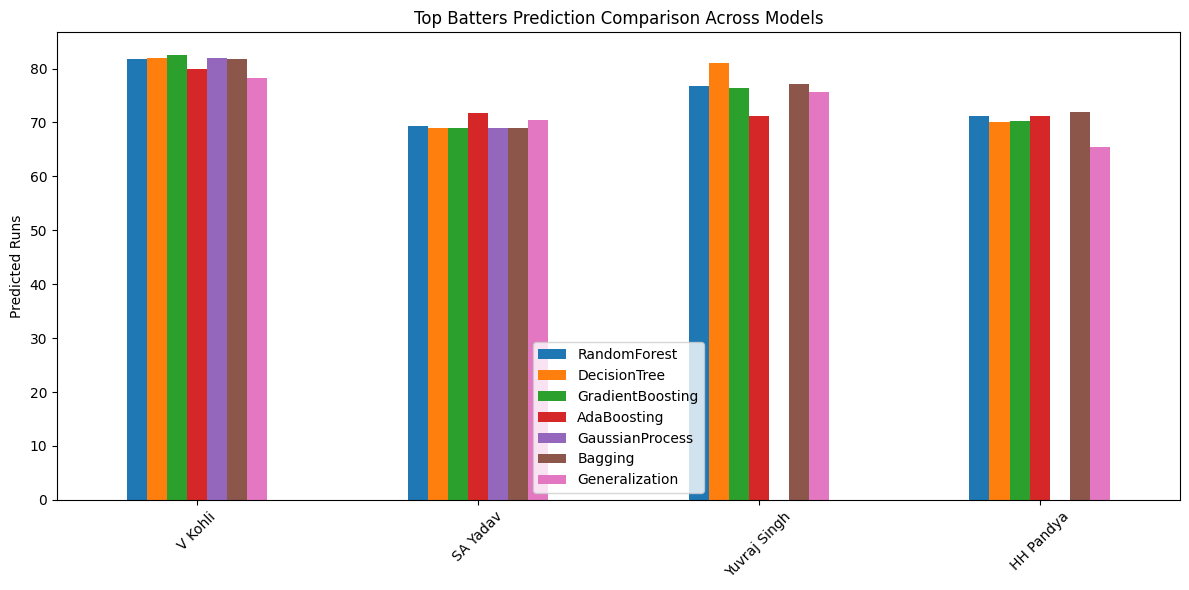

In [79]:
import matplotlib.pyplot as plt

batters_dict = {}

# Aggregate runs per player from each model
for model_name, df in top_batters_by_model.items():
    for _, row in df.iterrows():
        player = row["player"]
        runs = row["predicted_runs"]
        if player not in batters_dict:
            batters_dict[player] = {}
        batters_dict[player][model_name] = runs

# Build DataFrame
comparison_df = pd.DataFrame.from_dict(batters_dict, orient="index").fillna(0)

# Optional: Keep top 4 players by average predicted runs
top_players = comparison_df.mean(axis=1).sort_values(ascending=False).head(4).index
comparison_df = comparison_df.loc[top_players]

# Plot
comparison_df.plot(kind='bar', figsize=(12, 6))
plt.ylabel("Predicted Runs")
plt.title("Top Batters Prediction Comparison Across Models")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


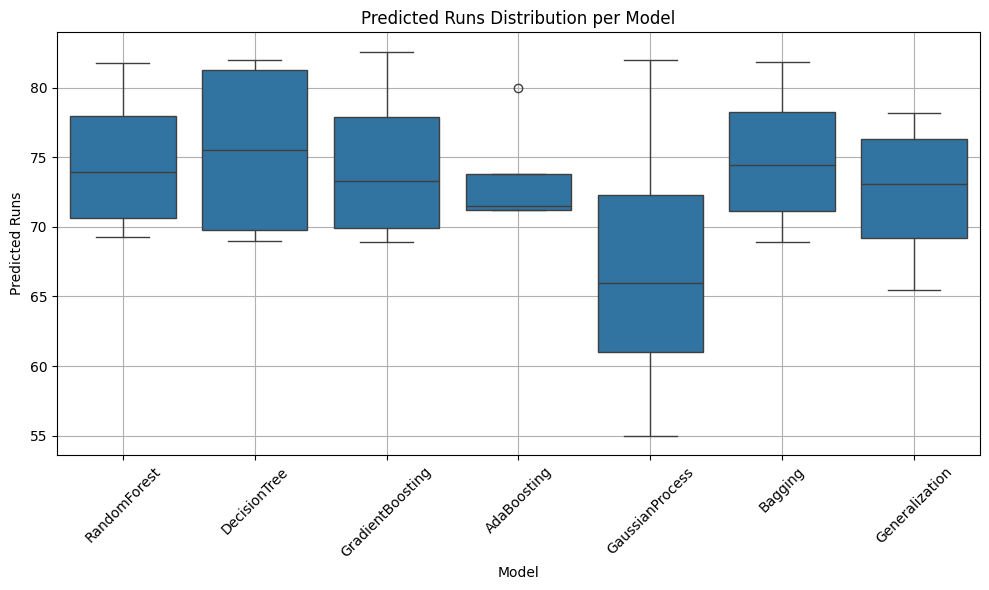

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Step 1: Flatten into a long-form DataFrame
boxplot_data = []

for model_name, df in top_batters_by_model.items():
    for _, row in df.iterrows():
        boxplot_data.append({
            "Model": model_name,
            "Predicted Runs": row["predicted_runs"]
        })

boxplot_df = pd.DataFrame(boxplot_data)

# Step 2: Plot the box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x="Model", y="Predicted Runs", data=boxplot_df)
plt.title("Predicted Runs Distribution per Model")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


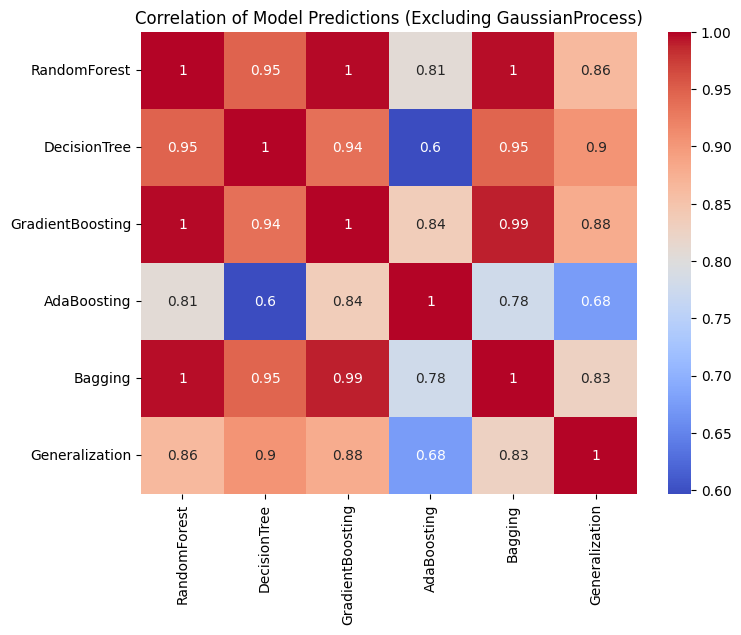

In [94]:
# Construct DataFrame with players as index, models as columns (excluding GaussianProcess)
comparison_df = pd.DataFrame()

for model_name, df in top_batters_by_model.items():
    if model_name != "GaussianProcess":
        comparison_df[model_name] = df.set_index("player")["predicted_runs"]

# Compute correlation matrix
corr_matrix = comparison_df.corr()

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation of Model Predictions (Excluding GaussianProcess)")
plt.show()



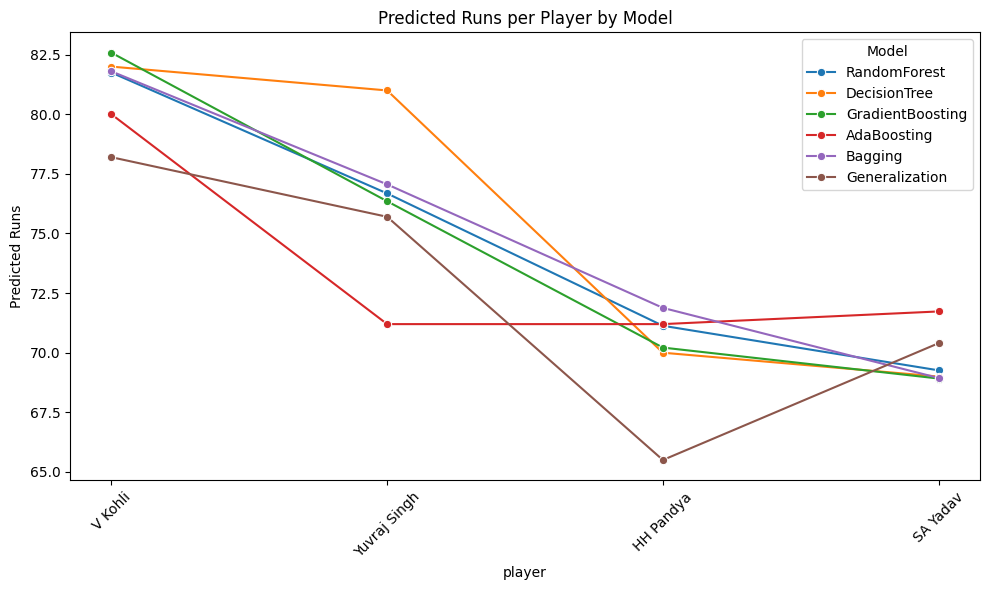

In [95]:
comparison_df = comparison_df.reset_index().melt(id_vars="player", var_name="Model", value_name="Predicted Runs")

plt.figure(figsize=(10, 6))
sns.lineplot(data=comparison_df, x="player", y="Predicted Runs", hue="Model", marker="o")
plt.xticks(rotation=45)
plt.title("Predicted Runs per Player by Model")
plt.tight_layout()
plt.show()


### Venue Type Comparison - Random Forest

Player_country = India

Opposition_country = Australia

#### venue_type = home

In [119]:
# Load the model
model_path = "/content/drive/MyDrive/SMAI_project/random_forest_model.pkl"
model = joblib.load(model_path)

# Input values
player_country = "India"
opposition_country = "Australia"
venue_type = "home"

# Step 1: Filter raw df
filtered_df = df[
    (df["player_country"] == player_country) &
    (df["opposition_country"] == opposition_country) &
    (df["venue_type"] == venue_type)
]

if filtered_df.empty:
    print("No data found for the given input.")
else:
    # Step 2: Match rows in df_final using index
    filtered_df_final = df_final.loc[filtered_df.index]

    # Step 3: Ensure correct feature columns (exclude target/irrelevant)
    feature_cols = [col for col in df_final.columns if col not in ["player", "runs"]]

    # Step 4: Predict runs
    X = filtered_df[["4s", "6s", "strike_rate", "BF", "year"]]
    #X = filtered_df_final[feature_cols]
    predicted_runs = model.predict(X)

    # Step 5: Use your function structure
    result_df = filtered_df[["player"]].copy()
    result_df["predicted_runs"] = predicted_runs

    print("\n✅ Predicted Runs for Players:")
    print(result_df)

    # Step 6: Prepare player_df (raw version) with added predictions
    player_df = filtered_df.copy()
    player_df["predicted_runs"] = predicted_runs

        # Step 7: Use your predict_top_batters function
    def predict_top_batters(player_df, top_n=4):
        results_df = player_df[["player", "player_country", "opposition_country", "venue_type", "predicted_runs"]].copy()

        # Get max predicted run per player
        results_unique = results_df.groupby("player", as_index=False)["predicted_runs"].max()

        # Add back context (optional)
        context = results_df.drop_duplicates(subset=["player"])[["player", "player_country", "opposition_country", "venue_type"]]
        final_results = pd.merge(results_unique, context, on="player", how="left")

        # Sort and get top N
        top_batters = final_results.sort_values(by="predicted_runs", ascending=False).head(top_n)
        return top_batters

    top_rf_home = predict_top_batters(player_df)

    print("\n🏏 Top 4 Predicted Batters (RandomForest_home):")
    print(top_rf_home)

    # ✅ Save results for comparison
    top_batters_by_model["RandomForest_home"] = top_rf_home




✅ Predicted Runs for Players:
             player  predicted_runs
179         V Kohli           81.75
251    Yuvraj Singh           76.68
347         V Kohli           71.78
379       HH Pandya           71.13
446        SA Yadav           69.26
...             ...             ...
14388       RR Pant            1.00
14718      KL Rahul            1.00
14829     YS Chahal            0.00
15553       V Kohli            0.00
16296      SA Yadav            0.00

[66 rows x 2 columns]

🏏 Top 4 Predicted Batters (RandomForest_home):
          player  predicted_runs player_country opposition_country venue_type
20       V Kohli           81.75          India          Australia       home
23  Yuvraj Singh           76.68          India          Australia       home
3      HH Pandya           71.13          India          Australia       home
17      SA Yadav           69.26          India          Australia       home


#### venue_type = away

In [120]:
# Load the model
model_path = "/content/drive/MyDrive/SMAI_project/random_forest_model.pkl"
model = joblib.load(model_path)

# Input values
player_country = "India"
opposition_country = "Australia"
venue_type = "away"

# Step 1: Filter raw df
filtered_df = df[
    (df["player_country"] == player_country) &
    (df["opposition_country"] == opposition_country) &
    (df["venue_type"] == venue_type)
]

if filtered_df.empty:
    print("No data found for the given input.")
else:
    # Step 2: Match rows in df_final using index
    filtered_df_final = df_final.loc[filtered_df.index]

    # Step 3: Ensure correct feature columns (exclude target/irrelevant)
    feature_cols = [col for col in df_final.columns if col not in ["player", "runs"]]

    # Step 4: Predict runs
    X = filtered_df[["4s", "6s", "strike_rate", "BF", "year"]]
    #X = filtered_df_final[feature_cols]
    predicted_runs = model.predict(X)

    # Step 5: Use your function structure
    result_df = filtered_df[["player"]].copy()
    result_df["predicted_runs"] = predicted_runs

    print("\n✅ Predicted Runs for Players:")
    print(result_df)

    # Step 6: Prepare player_df (raw version) with added predictions
    player_df = filtered_df.copy()
    player_df["predicted_runs"] = predicted_runs

        # Step 7: Use your predict_top_batters function
    def predict_top_batters(player_df, top_n=4):
        results_df = player_df[["player", "player_country", "opposition_country", "venue_type", "predicted_runs"]].copy()

        # Get max predicted run per player
        results_unique = results_df.groupby("player", as_index=False)["predicted_runs"].max()

        # Add back context (optional)
        context = results_df.drop_duplicates(subset=["player"])[["player", "player_country", "opposition_country", "venue_type"]]
        final_results = pd.merge(results_unique, context, on="player", how="left")

        # Sort and get top N
        top_batters = final_results.sort_values(by="predicted_runs", ascending=False).head(top_n)
        return top_batters

    top_rf_away = predict_top_batters(player_df)

    print("\n🏏 Top 4 Predicted Batters (RandomForest_away):")
    print(top_rf_away)

    # ✅ Save results for comparison
    top_batters_by_model["RandomForest_away"] = top_rf_away




✅ Predicted Runs for Players:
            player  predicted_runs
91         V Kohli           90.15
148        V Kohli           84.15
279       S Dhawan           75.86
673        V Kohli           61.16
731      RG Sharma           59.80
...            ...             ...
14966  S Sreesanth            0.00
15124    RG Sharma            0.00
15652      RR Pant            0.00
15911     KL Rahul            0.00
15912      SS Iyer            0.00

[74 rows x 2 columns]

🏏 Top 4 Predicted Batters (RandomForest_away):
       player  predicted_runs player_country opposition_country venue_type
24    V Kohli           90.15          India          Australia       away
18   S Dhawan           75.86          India          Australia       away
15  RG Sharma           59.80          India          Australia       away
1   G Gambhir           54.34          India          Australia       away


#### venue_type = neutral

In [121]:
# Load the model
model_path = "/content/drive/MyDrive/SMAI_project/random_forest_model.pkl"
model = joblib.load(model_path)

# Input values
player_country = "India"
opposition_country = "Australia"
venue_type = "neutral"

# Step 1: Filter raw df
filtered_df = df[
    (df["player_country"] == player_country) &
    (df["opposition_country"] == opposition_country) &
    (df["venue_type"] == venue_type)
]

if filtered_df.empty:
    print("No data found for the given input.")
else:
    # Step 2: Match rows in df_final using index
    filtered_df_final = df_final.loc[filtered_df.index]

    # Step 3: Ensure correct feature columns (exclude target/irrelevant)
    feature_cols = [col for col in df_final.columns if col not in ["player", "runs"]]

    # Step 4: Predict runs
    X = filtered_df[["4s", "6s", "strike_rate", "BF", "year"]]
    #X = filtered_df_final[feature_cols]
    predicted_runs = model.predict(X)

    # Step 5: Use your function structure
    result_df = filtered_df[["player"]].copy()
    result_df["predicted_runs"] = predicted_runs

    print("\n✅ Predicted Runs for Players:")
    print(result_df)

    # Step 6: Prepare player_df (raw version) with added predictions
    player_df = filtered_df.copy()
    player_df["predicted_runs"] = predicted_runs

        # Step 7: Use your predict_top_batters function
    def predict_top_batters(player_df, top_n=4):
        results_df = player_df[["player", "player_country", "opposition_country", "venue_type", "predicted_runs"]].copy()

        # Get max predicted run per player
        results_unique = results_df.groupby("player", as_index=False)["predicted_runs"].max()

        # Add back context (optional)
        context = results_df.drop_duplicates(subset=["player"])[["player", "player_country", "opposition_country", "venue_type"]]
        final_results = pd.merge(results_unique, context, on="player", how="left")

        # Sort and get top N
        top_batters = final_results.sort_values(by="predicted_runs", ascending=False).head(top_n)
        return top_batters

    top_rf_neutral = predict_top_batters(player_df)

    print("\n🏏 Top 4 Predicted Batters (RandomForest_neutral):")
    print(top_rf)

    # ✅ Save results for comparison
    top_batters_by_model["RandomForest_neutral"] = top_rf_neutral




✅ Predicted Runs for Players:
                player  predicted_runs
408       Yuvraj Singh           70.73
727       Yuvraj Singh           60.01
2468          MS Dhoni           36.10
2689        RV Uthappa           34.01
3102         IK Pathan           31.04
3915          SK Raina           26.00
4263         G Gambhir           24.02
4307          MS Dhoni           24.00
4497           V Kohli           23.00
5443         AM Rahane           19.00
5960         G Gambhir           17.00
6167          R Ashwin           16.00
6557           V Kohli           15.00
6558          MS Dhoni           15.00
8797          V Sehwag            9.00
9153         RG Sharma            8.00
9322      Yuvraj Singh            8.00
10435         SK Raina            6.00
11049        RG Sharma            5.00
12376        RA Jadeja            3.00
12740         R Ashwin            2.00
13618  Harbhajan Singh            1.00
14070        RG Sharma            1.00
14753        IK Pathan           

#### plots

In [122]:

# Merge into one DataFrame
venue_comparison_df = pd.DataFrame()

for venue, df in zip(['Home', 'Away', 'Neutral'], [top_rf_home, top_rf_away, top_rf_neutral]):
    temp = df[["player", "predicted_runs"]].copy()
    temp.columns = ["player", venue]
    if venue_comparison_df.empty:
        venue_comparison_df = temp
    else:
        venue_comparison_df = pd.merge(venue_comparison_df, temp, on="player", how="outer")


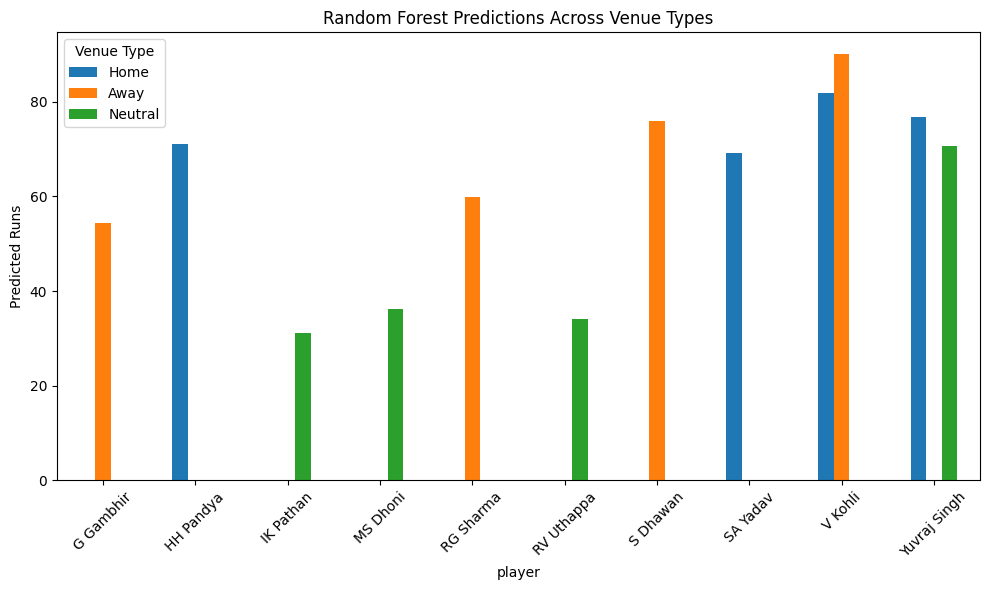

In [127]:
venue_comparison_df.set_index("player").plot(kind="bar", figsize=(10, 6))
plt.title( "Random Forest Predictions Across Venue Types")
plt.ylabel("Predicted Runs")
plt.xticks(rotation=45)
plt.legend(title="Venue Type")
plt.tight_layout()
plt.show()


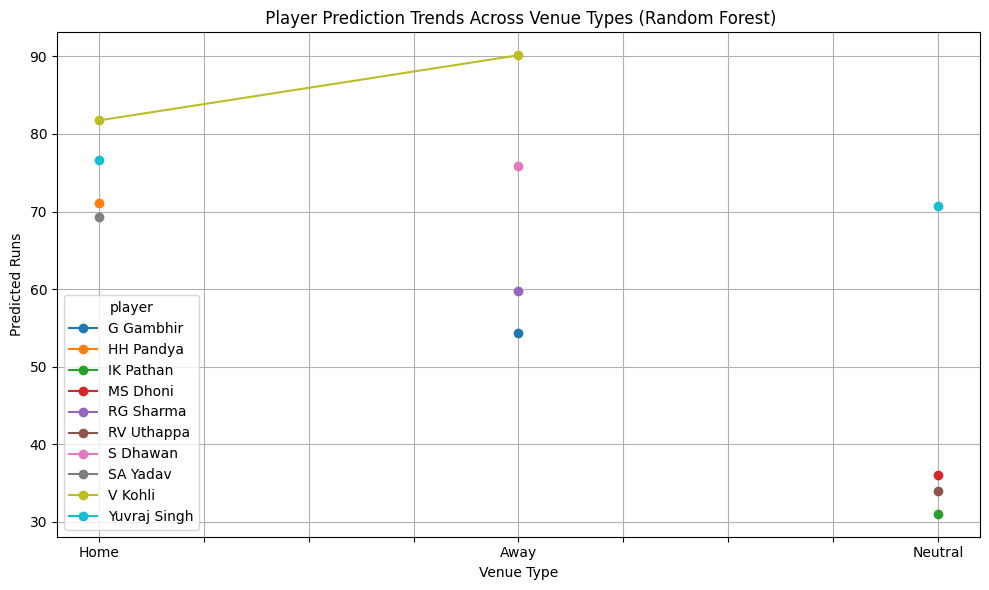

In [125]:
venue_comparison_df.set_index("player").T.plot(kind="line", marker='o', figsize=(10, 6))
plt.title(" Player Prediction Trends Across Venue Types (Random Forest)")
plt.xlabel("Venue Type")
plt.ylabel("Predicted Runs")
plt.grid(True)
plt.tight_layout()
plt.show()


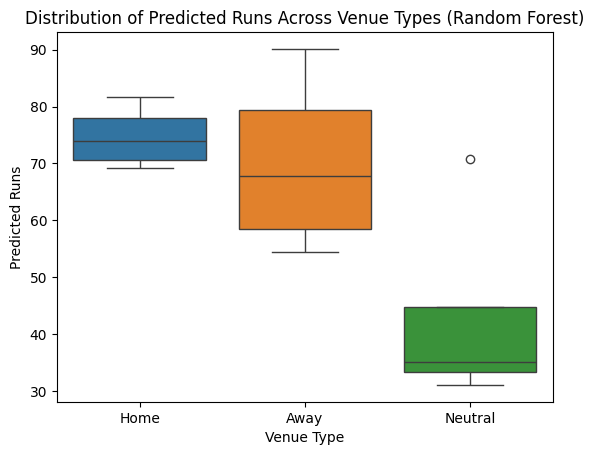

In [129]:
sns.boxplot(data=venue_comparison_df[["Home", "Away", "Neutral"]])
plt.title("Distribution of Predicted Runs Across Venue Types (Random Forest)")
plt.ylabel("Predicted Runs")
plt.xlabel("Venue Type")
plt.show()


In [130]:
print(venue_comparison_df[["Home", "Away", "Neutral"]].describe())


            Home       Away    Neutral
count   4.000000   4.000000   4.000000
mean   74.705000  70.037500  42.970000
std     5.655714  16.223769  18.622755
min    69.260000  54.340000  31.040000
25%    70.662500  58.435000  33.267500
50%    73.905000  67.830000  35.055000
75%    77.947500  79.432500  44.757500
max    81.750000  90.150000  70.730000


In [131]:
venue_means = venue_comparison_df[["Home", "Away", "Neutral"]].mean()
print(venue_means)


Home       74.7050
Away       70.0375
Neutral    42.9700
dtype: float64
